# BentoML Example: Keras Fashion MNIST

**BentoML makes moving trained ML models to production easy:**

* Package models trained with **any ML framework** and reproduce them for model serving in production
* **Deploy anywhere** for online API serving or offline batch serving
* High-Performance API model server with *adaptive micro-batching* support
* Central hub for managing models and deployment process via Web UI and APIs
* Modular and flexible design making it *adaptable to your infrastrcuture*

BentoML is a framework for serving, managing, and deploying machine learning models. It is aiming to bridge the gap between Data Science and DevOps, and enable teams to deliver prediction services in a fast, repeatable, and scalable way.

Before reading this example project, be sure to check out the [Getting started guide](https://github.com/bentoml/BentoML/blob/master/guides/quick-start/bentoml-quick-start-guide.ipynb) to learn about the basic concepts in BentoML.

This notebook demonstrates how to use BentoML to turn a Keras model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=keras&ea=keras-fashion-mnist&dt=keras-fashion-mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install -q bentoml tensorflow==1.14.0 numpy matplotlib keras==2.3.1 pillow

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print("Tensorflow Version: %s" % tf.__version__)

import keras
print("Keras Version: %s" % keras.__version__)

import bentoml
print("BentoML Version: %s" % bentoml.__version__)

Tensorflow Version: 1.14.0
Keras Version: 2.3.1
BentoML Version: 0.9.0.pre+7.g8af1c8b


## Load Fashion MNIST dataset

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

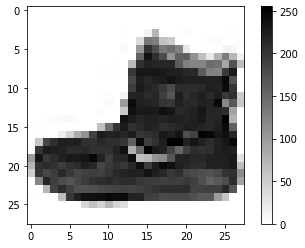

In [5]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

We should scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [6]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

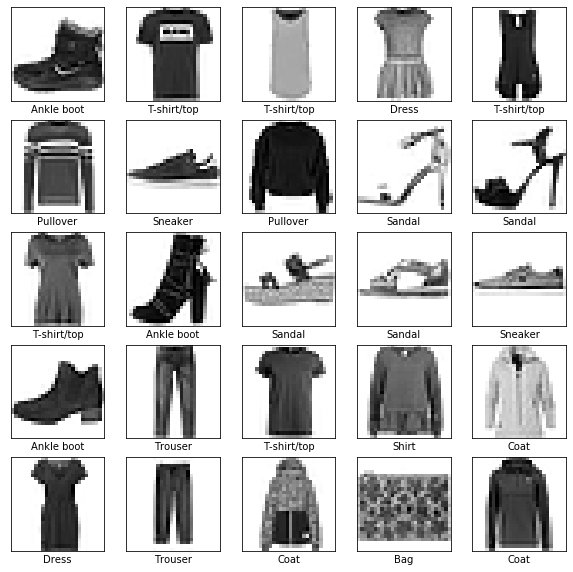

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [8]:
# Reshaping the images so that our model can accept it
train_images  = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

## Build the model

In [9]:
model = keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)            

## Compile the model

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

In [11]:
model.fit(train_images, train_labels, batch_size=64, epochs=5)


Epoch 1/5
60000/60000 [==============================] - 6s 101us/step - loss: 0.5853 - accuracy: 0.7847
Epoch 2/5
60000/60000 [==============================] - 5s 86us/step - loss: 0.4095 - accuracy: 0.8508
Epoch 3/5
60000/60000 [==============================] - 5s 86us/step - loss: 0.3620 - accuracy: 0.8662
Epoch 4/5
60000/60000 [==============================] - 5s 86us/step - loss: 0.3354 - accuracy: 0.8784
Epoch 5/5
60000/60000 [==============================] - 5s 85us/step - loss: 0.3190 - accuracy: 0.8843


## Evaluate model accuracy

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 52us/step
Test accuracy: 0.899399995803833


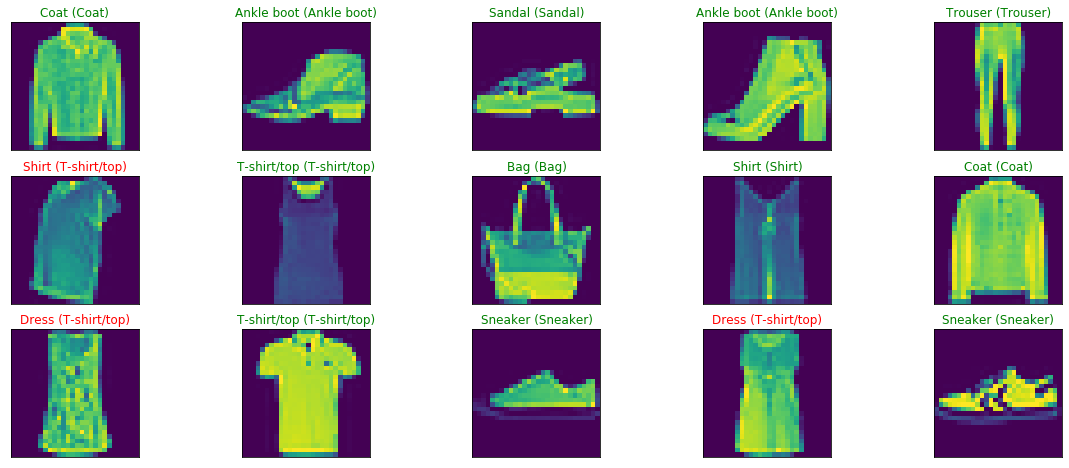

In [13]:
y_hat = model.predict_classes(test_images)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = y_hat[index]
    true_index = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Predict on a single image

Let's first see the test image and and its label:

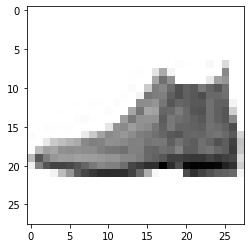

Class: Ankle boot


In [14]:
plt.imshow(test_images[0].squeeze(-1), cmap=plt.cm.binary)
plt.show()
print('Class:', class_names[test_labels[0]])

In [15]:
pred_idx = model.predict_classes(np.expand_dims(test_images[0], 0))[0]
print('Prediction:', class_names[pred_idx])

Prediction: Ankle boot


## Define BentoService for model serving

In [18]:
%%writefile keras_fashion_mnist.py
from typing import List

import numpy as np
from PIL import Image
from bentoml import api, artifacts, env, BentoService
from bentoml.frameworks.keras import KerasModelArtifact
from bentoml.adapters import ImageInput

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

@env(pip_packages=['keras==2.3.1', 'tensorflow==1.14.0', 'pillow', 'numpy'])
@artifacts([KerasModelArtifact('classifier')])
class KerasFashionMnistService(BentoService):
        
    @api(input=ImageInput(pilmode='L'), batch=True)
    def predict(self, imgs: List[np.ndarray]) -> List[str]:
        inputs = []
        for img in imgs:
            img = Image.fromarray(img).resize((28, 28))
            img = np.array(img.getdata()).reshape((28, 28, 1))
            inputs.append(img)
        inputs = np.stack(inputs)
        class_idxs = self.artifacts.classifier.predict_classes(inputs)
        return [class_names[class_idx] for class_idx in class_idxs]

Overwriting keras_fashion_mnist.py


## Save BentoService to file archive

In [19]:
# 1) import the custom BentoService defined above
from keras_fashion_mnist import KerasFashionMnistService

# 2) `pack` it with required artifacts
mnist_svc = KerasFashionMnistService()
mnist_svc.pack('classifier', model)

# 3) save your BentoSerivce to file archive
saved_path = mnist_svc.save()

[2020-09-23 13:23:49,677] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 13:23:49,704] WARNING - pip package requirement tensorflow already exist

[2020-09-23 13:23:51,430] INFO - Detected non-PyPI-released BentoML installed, copying local BentoML modulefiles to target saved bundle path..


/opt/conda/envs/bentoml-py3_6-tf1_4/lib/python3.6/site-packages/setuptools/dist.py:452: UserWarning: Normalizing '0.9.0.pre+7.g8af1c8b' to '0.9.0rc0+7.g8af1c8b'
  warnings.warn(tmpl.format(**locals()))
no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


UPDATING BentoML-0.9.0rc0+7.g8af1c8b/bentoml/_version.py
set BentoML-0.9.0rc0+7.g8af1c8b/bentoml/_version.py to '0.9.0.pre+7.g8af1c8b'
[2020-09-23 13:23:52,274] INFO - BentoService bundle 'KerasFashionMnistService:20200923132350_974EEA' saved to: /home/bentoml/bentoml/repository/KerasFashionMnistService/20200923132350_974EEA


## Load saved BentoService

bentoml.load is the API for loading a BentoML packaged model in python:

In [20]:
svc = bentoml.load(saved_path)
svc.predict([test_images[0].squeeze(-1)])

[2020-09-23 13:23:59,176] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+7.g8af1c8b
[2020-09-23 13:23:59,178] WARNING - Module `keras_fashion_mnist` already loaded, using existing imported module.

[2020-09-23 13:24:00,085] WARNING - pip package requirement imageio already exist
[2020-09-23 13:24:00,086] WARNING - pip package requirement tensorflow already exist
[2020-09-23 13:24:00,087] WARNING - pip package requirement keras already exist


['Ankle boot']

## Launch inference job from CLI

BentoML cli supports loading and running a packaged model from CLI. With the DataframeInput adapter, the CLI command supports reading input Dataframe data from CLI argument or local csv or json files:

In [2]:
!bentoml run KerasFashionMnistService:latest predict --input-file sample_image.png

[2020-09-23 13:24:35,370] INFO - Getting latest version KerasFashionMnistService:20200923132350_974EEA
[2020-09-23 13:24:36,401] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 13:24:36,419] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+7.g8af1c8b
/opt/anaconda3/envs/bentoml-py3_6-tf1_4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/bentoml-py3_6-tf1_4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: Futu

## REST API Model Serving


To start a REST API model server with the BentoService saved above, use the bentoml serve command:

In [3]:
!bentoml serve KerasFashionMnistService:latest --enable-microbatch

[2020-09-23 13:24:48,477] INFO - Getting latest version KerasFashionMnistService:20200923132350_974EEA
[2020-09-23 13:24:48,477] INFO - Starting BentoML API server in development mode..
[2020-09-23 13:24:49,637] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 13:24:49,654] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+7.g8af1c8b
/opt/anaconda3/envs/bentoml-py3_6-tf1_4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/bentoml-py3_

If you are running this notebook from Google Colab, you can start the dev server with `--run-with-ngrok` option, to gain acccess to the API endpoint via a public endpoint managed by [ngrok](https://ngrok.com/):

In [ ]:
!bentoml serve KerasFashionMnistService:latest --run-with-ngrok

Test sending request to API Server from terminal:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@sample_image.png
```

or:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/png" --data-binary @sample_image.png
```

## Containerize model server with Docker


One common way of distributing this model API server for production deployment, is via Docker containers. And BentoML provides a convenient way to do that.

Note that docker is **not available in Google Colab**. You will need to download and run this notebook locally to try out this containerization with docker feature.

If you already have docker configured, simply run the follow command to product a docker container serving the IrisClassifier prediction service created above:

In [4]:
!bentoml containerize KerasFashionMnistService:latest -t kerasfashionmnistservice:latest

[2020-09-23 13:25:09,964] INFO - Getting latest version KerasFashionMnistService:20200923132350_974EEA
Found Bento: /home/bentoml/bentoml/repository/KerasFashionMnistService/20200923132350_974EEA
[2020-09-23 13:25:09,983] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 13:25:09,999] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+7.g8af1c8b
Building Docker image kerasfashionmnistservice:latest from KerasFashionMnistService:latest 
-Step 1/15 : FROM bentoml/model-server:0.9.0.pre-py36
 ---> 4aac43d10e50
Step 2/15 : ARG EXTRA_PIP_INSTALL_ARGS=
 ---> Using cache
 ---> 790054f5ad85
Step 3/15 : ENV EXTRA_PIP_INSTALL_ARGS $EXTRA_PIP_INSTALL_ARGS
 ---> Using cache
 ---> 85b0a1b40542
S

In [5]:
!docker run -p 5000:5000 kerasfashionmnistservice

[2020-09-23 05:35:06,581] INFO - Starting BentoML API server in production mode..
[2020-09-23 05:35:06,806] INFO - get_gunicorn_num_of_workers: 3, calculated by cpu count
[2020-09-23 05:35:06 +0000] [1] [INFO] Starting gunicorn 20.0.4
[2020-09-23 05:35:06 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2020-09-23 05:35:06 +0000] [1] [INFO] Using worker: sync
[2020-09-23 05:35:06 +0000] [13] [INFO] Booting worker with pid: 13
[2020-09-23 05:35:06 +0000] [14] [INFO] Booting worker with pid: 14
[2020-09-23 05:35:06 +0000] [15] [INFO] Booting worker with pid: 15
[2020-09-23 05:35:07,826] WARNING - Using BentoML not from official PyPI release. In order to find the same version of BentoML when deploying your BentoService, you must set the 'core/bentoml_deploy_version' config to a http/git location of your BentoML fork, e.g.: 'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-09-23 05:35:07,847] WARNING - Saved BentoService bundle version mismatch

# Deployment Options

If you are at a small team with limited engineering or DevOps resources, try out automated deployment with BentoML CLI, currently supporting AWS Lambda, AWS SageMaker, and Azure Functions:
- [AWS Lambda Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_lambda.html)
- [AWS SageMaker Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_sagemaker.html)
- [Azure Functions Deployment Guide](https://docs.bentoml.org/en/latest/deployment/azure_functions.html)

If the cloud platform you are working with is not on the list above, try out these step-by-step guide on manually deploying BentoML packaged model to cloud platforms:
- [AWS ECS Deployment](https://docs.bentoml.org/en/latest/deployment/aws_ecs.html)
- [Google Cloud Run Deployment](https://docs.bentoml.org/en/latest/deployment/google_cloud_run.html)
- [Azure container instance Deployment](https://docs.bentoml.org/en/latest/deployment/azure_container_instance.html)
- [Heroku Deployment](https://docs.bentoml.org/en/latest/deployment/heroku.html)

Lastly, if you have a DevOps or ML Engineering team who's operating a Kubernetes or OpenShift cluster, use the following guides as references for implementating your deployment strategy:
- [Kubernetes Deployment](https://docs.bentoml.org/en/latest/deployment/kubernetes.html)
- [Knative Deployment](https://docs.bentoml.org/en/latest/deployment/knative.html)
- [Kubeflow Deployment](https://docs.bentoml.org/en/latest/deployment/kubeflow.html)
- [KFServing Deployment](https://docs.bentoml.org/en/latest/deployment/kfserving.html)
- [Clipper.ai Deployment Guide](https://docs.bentoml.org/en/latest/deployment/clipper.html)